In [74]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import haversine_distances
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

In [75]:
# Loading telecom dataset
telecom_data = pd.read_csv('cellular_dataframe.csv')

# remove nan values in latitudes and longitudes in telecom_data
telecom_data = telecom_data[~np.isnan(telecom_data['Latitude'])]
telecom_data = telecom_data[~np.isnan(telecom_data['Longitude'])]
#remove nan values in PCell_Downlink_Num_RBs, PCell_Downlink_TB_Size, SCell_Downlink_TB_Size and datarate
telecom_data = telecom_data[~np.isnan(telecom_data['PCell_Downlink_Num_RBs'])]
telecom_data = telecom_data[~np.isnan(telecom_data['PCell_Downlink_TB_Size'])]
telecom_data = telecom_data[~np.isnan(telecom_data['SCell_Downlink_TB_Size'])]
telecom_data = telecom_data[~np.isnan(telecom_data['SCell_Downlink_Num_RBs'])]
telecom_data = telecom_data[~np.isnan(telecom_data['SCell_Downlink_RBs_MCS_28'])]
telecom_data = telecom_data[~np.isnan(telecom_data['SCell_Downlink_RBs_MCS_31'])]
telecom_data = telecom_data[~np.isnan(telecom_data['datarate'])]

# selecting a random 10000 rows from the dataset
# telecom_data = telecom_data.sample(n=10000, random_state=42)
telecom_data['datarate'] = ((np.max(telecom_data['datarate'])-telecom_data['datarate'])*100)/(np.max(telecom_data['datarate'])-np.min(telecom_data['datarate']))

#splitting the dataset into train and test sets
train_data, test_data = train_test_split(telecom_data, test_size=0.2, random_state=42)

telecom_data = train_data

print(telecom_data.shape)
print(test_data.shape)

# Extract relevant features and labels
features = telecom_data[['PCell_Downlink_Num_RBs', 'PCell_Downlink_TB_Size', 'SCell_Downlink_TB_Size','SCell_Downlink_Num_RBs','SCell_Downlink_RBs_MCS_28','SCell_Downlink_RBs_MCS_31']].values
labels = telecom_data['datarate'].values  # Replace 'label' with your actual label column
# normalizing the labels using min-max normalization
labels = ((np.max(labels)-labels)*100)/(np.max(labels)-np.min(labels))

 
# Extract latitudes and longitudes
latitudes = telecom_data['Latitude'].values
longitudes = telecom_data['Longitude'].values

(3319, 159)
(664, 159)


In [76]:
# finding min and max values of labels
print(np.min(labels), np.max(labels))

0.0 100.0


In [77]:
# Calculate pairwise distances using Haversine formula
coordinates = np.column_stack((latitudes, longitudes))
dist_matrix = haversine_distances(np.radians(coordinates))

# Define distance threshold for edges
distance_threshold = 1  # For example, consider nodes within 10 km as neighbors

In [78]:

# Create adjacency matrix based on distance threshold
adj_matrix = (dist_matrix <= distance_threshold).astype(int)

# Convert adjacency matrix to edge indices
edge_indices = np.transpose(np.nonzero(adj_matrix))
edge_indices = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()


In [79]:
# Split data into train and test sets
X_train, y_train = features,labels
y_train= y_train.reshape(-1,1)

In [80]:
X_train.shape

(3319, 6)

In [81]:
# Convert data to tensors
x = torch.FloatTensor(X_train)
y = torch.FloatTensor(y_train)

In [82]:
# Create a graph data object using torch_geometric
data = Data(x=x, edge_index=edge_indices, y=y)

In [83]:
from torch_geometric.nn import SAGEConv

class ComplexGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ComplexGNN, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, hidden_dim)
        self.conv4 = SAGEConv(hidden_dim, hidden_dim)
        self.conv5 = SAGEConv(hidden_dim, hidden_dim)
        self.conv6 = SAGEConv(hidden_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)  # Adding dropout for regularization
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = self.conv4(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv5(x, edge_index)
        x = torch.relu(x)
        x = self.conv6(x, edge_index)
        x = torch.relu(x)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        return x

In [84]:
# Define your loss function and optimizer
gnn_model = ComplexGNN(input_dim=features.shape[1], hidden_dim=16, output_dim=1)
# # loading a pytorch model from a saved state dict
# gnn_model.load_state_dict(torch.load('lat_long_node_GNN_220_3240.pth'))
loss_function = nn.MSELoss()  # For regression tasks
optimizer = optim.Adam(gnn_model.parameters(), lr=0.001)

# Create a DataLoader for batching your data
dataloader = DataLoader([data], batch_size=200)

In [85]:
# # loading training and validation loss from a pickle file
# import pickle
# with open('lat_long_node_GNN_220_3240.pkl', 'rb') as f:
#     training_acc, validation_acc = pickle.load(f)

In [86]:
training_acc = []
validation_acc = []

In [87]:
len(training_acc)

0

In [88]:
def get_validation(test_data):
    telecom_data = test_data
    # Extract relevant features and labels
    features = telecom_data[['PCell_Downlink_Num_RBs', 'PCell_Downlink_TB_Size', 'SCell_Downlink_TB_Size','SCell_Downlink_Num_RBs','SCell_Downlink_RBs_MCS_28','SCell_Downlink_RBs_MCS_31']].values
    labels = telecom_data['datarate'].values  # Replace 'label' with your actual label column
    # # normalizing the labels using min-max normalization
    # labels = ((np.max(labels)-labels)*100)/(np.max(labels)-np.min(labels))
    
     
    # Extract latitudes and longitudes
    latitudes = telecom_data['Latitude'].values
    longitudes = telecom_data['Longitude'].values
    
    # Calculate pairwise distances using Haversine formula
    coordinates = np.column_stack((latitudes, longitudes))
    dist_matrix = haversine_distances(np.radians(coordinates))
    
    # Define distance threshold for edges
    distance_threshold = 1  # For example, consider nodes within 10 km as neighbors
    
    # Create adjacency matrix based on distance threshold
    adj_matrix = (dist_matrix <= distance_threshold).astype(int)
    
    # Convert adjacency matrix to edge indices
    edge_indices = np.transpose(np.nonzero(adj_matrix))
    edge_indices = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    
    loss_function = nn.MSELoss()
    
    X_train, y_train = features,labels
    y_train= y_train.reshape(-1,1)
    # Convert data to tensors
    x = torch.FloatTensor(X_train)
    y = torch.FloatTensor(y_train)
    # Create a graph data object using torch_geometric
    data = Data(x=x, edge_index=edge_indices, y=y)
    dataloader = DataLoader([data], batch_size=200)
    # Evaluation on test set
    gnn_model.eval()
    with torch.no_grad():
        for batch_data in dataloader:
            #print(batch_data.x.shape, batch_data.edge_index.shape, batch_data.y.shape)
            output = gnn_model(batch_data.x, batch_data.edge_index)
            loss = loss_function(output, batch_data.y)
            # print(f"Epoch [{epoch + 1}/{num_epochs}], Batch Loss: {(loss.item()):.4f}")
            return loss.item()

In [89]:
# Training loop
num_epochs = 2500

for epoch in range(num_epochs):
    #setting best validation loss to infinity
    best_val_loss = np.inf
    for batch_data in dataloader:
        optimizer.zero_grad()
        # print(batch_data.x.shape, batch_data.edge_index.shape, batch_data.y.shape)
        output = gnn_model(batch_data.x, batch_data.edge_index)
        loss = loss_function(output, batch_data.y)
        loss.backward()
        optimizer.step()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Batch Loss: {(loss.item()):.4f}")
        val_loss = get_validation(test_data)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {(val_loss):.4f}")
        print("--------------------------------------------------")
        training_acc.append(loss.item())
        validation_acc.append(val_loss)
        # saving the model with best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(gnn_model.state_dict(), 'lat_long_node_GNN_220_3240_best.pth')

Epoch [1/2500], Batch Loss: 864052608.0000
Epoch [1/2500], Validation Loss: 144862352.0000
--------------------------------------------------
Epoch [2/2500], Batch Loss: 141224304.0000
Epoch [2/2500], Validation Loss: 20150376.0000
--------------------------------------------------
Epoch [3/2500], Batch Loss: 19626996.0000
Epoch [3/2500], Validation Loss: 2501337.5000
--------------------------------------------------
Epoch [4/2500], Batch Loss: 2458985.2500
Epoch [4/2500], Validation Loss: 24418306.0000
--------------------------------------------------
Epoch [5/2500], Batch Loss: 23836778.0000
Epoch [5/2500], Validation Loss: 37101256.0000
--------------------------------------------------
Epoch [6/2500], Batch Loss: 36206272.0000
Epoch [6/2500], Validation Loss: 31788174.0000
--------------------------------------------------
Epoch [7/2500], Batch Loss: 31063476.0000
Epoch [7/2500], Validation Loss: 16908338.0000
--------------------------------------------------
Epoch [8/2500], Bat

In [90]:
print(min(validation_acc))
#1112.86

3262.095947265625


In [91]:
print(len(validation_acc))

2500


In [106]:
# print last 100 validation losses
print(validation_acc[-100:])


[3838.283935546875, 3845.311767578125, 3842.6904296875, 3840.603271484375, 3849.58251953125, 3837.966796875, 3846.280029296875, 3840.7744140625, 3840.8896484375, 3845.048828125, 3839.548583984375, 3843.17236328125, 3842.209716796875, 3842.3681640625, 3839.7255859375, 3842.9033203125, 3837.7470703125, 3843.0751953125, 3833.5244140625, 3848.642333984375, 3832.052734375, 3853.73486328125, 3828.73046875, 3856.846435546875, 3830.410400390625, 3850.367431640625, 3837.094970703125, 3839.2666015625, 3850.2470703125, 3828.156982421875, 3863.407470703125, 3811.009033203125, 3881.844482421875, 3796.70849609375, 3884.05078125, 3802.49853515625, 3869.303955078125, 3821.65966796875, 3841.224365234375, 3849.5390625, 3813.30908203125, 3870.079833984375, 3793.8779296875, 3892.310302734375, 3774.795166015625, 3909.510986328125, 3760.259033203125, 3922.53271484375, 3748.7119140625, 3935.583984375, 3744.456787109375, 3937.878662109375, 3746.540283203125, 3935.058837890625, 3758.5869140625, 3929.6257324218

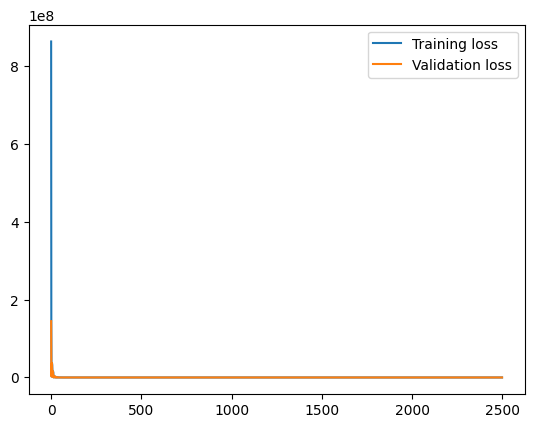

In [92]:
# plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(training_acc, label='Training loss')
plt.plot(validation_acc, label='Validation loss')
plt.legend()
plt.show()

In [93]:
# saving the model
torch.save(gnn_model.state_dict(), 'lat_long_node_GNN_220_3240.pth')

In [94]:
# saving the validation loss and training loss as a pickle file
import pickle
with open('lat_long_node_GNN_220_3240.pkl', 'wb') as f:
    pickle.dump([training_acc, validation_acc], f)

In [95]:
def evaluate_model(telecom_data):
    # Extract relevant features and labels
    features = telecom_data[['PCell_Downlink_Num_RBs', 'PCell_Downlink_TB_Size', 'SCell_Downlink_TB_Size','SCell_Downlink_Num_RBs','SCell_Downlink_RBs_MCS_28','SCell_Downlink_RBs_MCS_31']].values
    labels = telecom_data['datarate'].values  # Replace 'label' with your actual label column
    
    # # Normalizing the labels using min-max normalization
    # labels = ((np.max(labels)-labels)*100)/(np.max(labels)-np.min(labels))
    
    # Extract latitudes and longitudes
    latitudes = telecom_data['Latitude'].values
    longitudes = telecom_data['Longitude'].values
    
    # Calculate pairwise distances using Haversine formula
    coordinates = np.column_stack((latitudes, longitudes))
    dist_matrix = haversine_distances(np.radians(coordinates))
    
    # Define distance threshold for edges
    distance_threshold = 1  # Consider nodes within specified distance as neighbors
    
    # Create adjacency matrix based on distance threshold
    adj_matrix = (dist_matrix <= distance_threshold).astype(int)
    
    # Convert adjacency matrix to edge indices
    edge_indices = np.transpose(np.nonzero(adj_matrix))
    edge_indices = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    
    loss_function = nn.MSELoss()
    
    X_train, y_train = features,labels
    y_train= y_train.reshape(-1,1)
    
    # Convert data to tensors
    x = torch.FloatTensor(X_train)
    y = torch.FloatTensor(y_train)
    
    # Create a graph data object using torch_geometric
    data = Data(x=x, edge_index=edge_indices, y=y)
    dataloader = DataLoader([data], batch_size=20)
    
    # Evaluation on test set
    gnn_model.eval()
    
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for batch_data in dataloader:
            output = gnn_model(batch_data.x, batch_data.edge_index)
            
            true_labels.extend(batch_data.y.numpy())
            predicted_labels.extend(output.numpy())

    return true_labels, predicted_labels

In [96]:
a,b = evaluate_model(telecom_data=test_data)

In [97]:
print(a)

[array([68.69766], dtype=float32), array([64.0784], dtype=float32), array([48.409866], dtype=float32), array([68.25421], dtype=float32), array([85.84436], dtype=float32), array([52.105274], dtype=float32), array([52.844357], dtype=float32), array([49.14895], dtype=float32), array([73.464745], dtype=float32), array([48.409866], dtype=float32), array([66.7391], dtype=float32), array([81.705505], dtype=float32), array([35.10639], dtype=float32), array([41.75813], dtype=float32), array([49.888027], dtype=float32), array([73.68647], dtype=float32), array([30.302359], dtype=float32), array([65.076164], dtype=float32), array([61.3438], dtype=float32), array([92.0157], dtype=float32), array([28.824194], dtype=float32), array([30.6719], dtype=float32), array([60.604717], dtype=float32), array([57.278847], dtype=float32), array([77.75142], dtype=float32), array([42.866753], dtype=float32), array([74.092964], dtype=float32), array([90.35276], dtype=float32), array([60.235176], dtype=float32), arr

In [98]:
print(b)

[array([103.94014], dtype=float32), array([115.353226], dtype=float32), array([126.01338], dtype=float32), array([105.31123], dtype=float32), array([75.21065], dtype=float32), array([106.92354], dtype=float32), array([119.52022], dtype=float32), array([136.33565], dtype=float32), array([106.74092], dtype=float32), array([119.5544], dtype=float32), array([105.05733], dtype=float32), array([97.57002], dtype=float32), array([146.7878], dtype=float32), array([134.49483], dtype=float32), array([119.27608], dtype=float32), array([108.402054], dtype=float32), array([144.98506], dtype=float32), array([108.45479], dtype=float32), array([107.20772], dtype=float32), array([100.083694], dtype=float32), array([133.83662], dtype=float32), array([150.86983], dtype=float32), array([113.55928], dtype=float32), array([110.84444], dtype=float32), array([95.73213], dtype=float32), array([123.01045], dtype=float32), array([104.552444], dtype=float32), array([103.26338], dtype=float32), array([140.40694], d

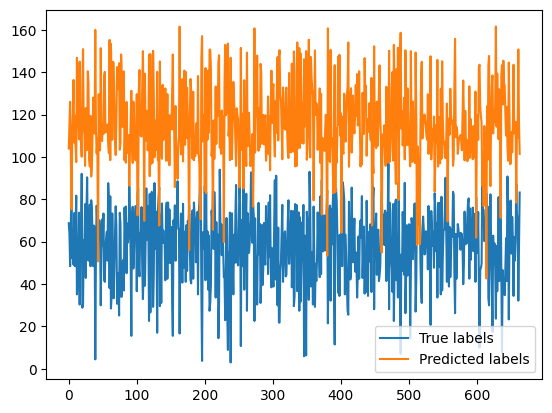

In [99]:
# plotting the graph for a and b
import matplotlib.pyplot as plt
plt.plot(a, label='True labels')
plt.plot(b, label='Predicted labels')
plt.legend()
plt.show()

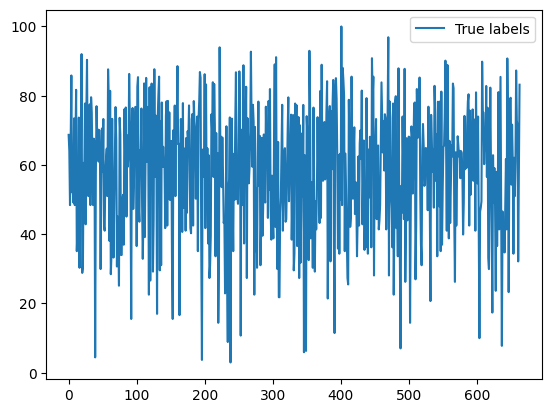

In [100]:
# displaying the true and predicted labels in different graphs
import matplotlib.pyplot as plt
plt.plot(a, label='True labels')
plt.legend()
plt.show()

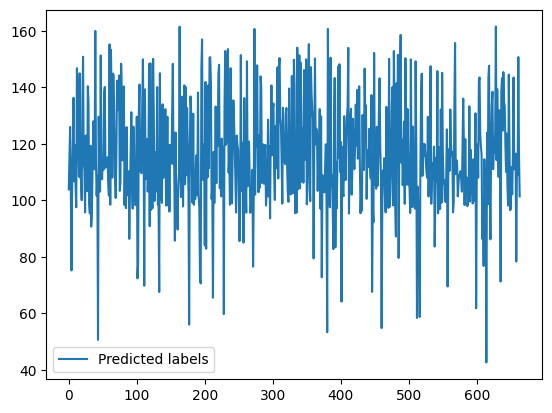

In [101]:
plt.plot(b, label='Predicted labels')
plt.legend()
plt.show()


In [102]:
# calculating the mean absolute error
from sklearn.metrics import mean_absolute_error
mean_absolute_error(a,b)

58.65011

In [103]:
# calculating the mean squared error
from sklearn.metrics import mean_squared_error
mean_squared_error(a,b)

4661.1377

In [104]:
# calculating the root mean squared error
from sklearn.metrics import mean_squared_error
mean_squared_error(a,b, squared=False)

68.27252

In [105]:
# calculating the r2 score
from sklearn.metrics import r2_score
r2_score(a,b)

-12.36877611670523

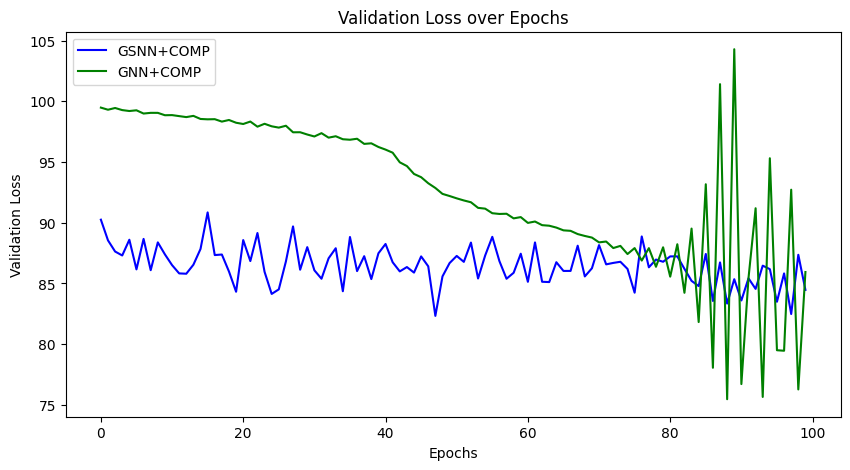

In [108]:
import matplotlib.pyplot as plt

# Data
gsnn_comp = [90.25334930419922, 88.5505142211914, 87.63139343261719, 87.3066635131836, 88.60247802734375, 86.16129302978516, 88.67098999023438, 86.09484100341797, 88.38377380371094, 87.3938217163086, 86.51296997070312, 85.82942199707031, 85.8031005859375, 86.54318237304688, 87.84183502197266, 90.85400390625, 87.3396224975586, 87.38410949707031, 85.98375701904297, 84.3191146850586, 88.575439453125, 86.84466552734375, 89.15631103515625, 85.95929718017578, 84.1384506225586, 84.51542663574219, 86.81652069091797, 89.70099639892578, 86.13388061523438, 87.99203491210938, 86.08554077148438, 85.39020538330078, 87.07389068603516, 87.90162658691406, 84.36145782470703, 88.82559967041016, 86.01966857910156, 87.24775695800781, 85.3617172241211, 87.48590850830078, 88.25421905517578, 86.74718475341797, 85.99500274658203, 86.35236358642578, 85.8949966430664, 87.22938537597656, 86.4119873046875, 82.332275390625, 85.58155059814453, 86.68164825439453, 87.26866149902344, 86.78034973144531, 88.36884307861328, 85.41046905517578, 87.30697631835938, 88.84124755859375, 86.84275817871094, 85.38978576660156, 85.88221740722656, 87.45079803466797, 85.13636016845703, 88.38259887695312, 85.14080047607422, 85.11553955078125, 86.751220703125, 86.03270721435547, 86.03434753417969, 88.11173248291016, 85.58016967773438, 86.25173950195312, 88.16060638427734, 86.57479095458984, 86.69314575195312, 86.78727722167969, 86.19976806640625, 84.24078369140625, 88.87478637695312, 86.3310546875, 86.96847534179688, 86.78877258300781, 87.23017120361328, 87.23188018798828, 86.20516967773438, 85.21394348144531, 84.78611755371094, 87.43270874023438, 83.56169128417969, 86.7362289428711, 83.3440170288086, 85.35220336914062, 83.60159301757812, 85.423828125, 84.5544204711914, 86.46781921386719, 86.18049621582031, 83.49463653564453, 85.82938385009766, 82.48554992675781, 87.3623275756836, 84.47284698486328]

gnn_comp = [99.48250579833984, 99.30841827392578, 99.45175170898438, 99.2787094116211, 99.20259857177734, 99.26128387451172, 98.99451446533203, 99.0519027709961, 99.0507583618164, 98.85538482666016, 98.86589050292969, 98.78237915039062, 98.70154571533203, 98.80227661132812, 98.5480728149414, 98.51824188232422, 98.5300521850586, 98.33113861083984, 98.46385192871094, 98.23704528808594, 98.13346099853516, 98.3337631225586, 97.91302490234375, 98.15076446533203, 97.94328308105469, 97.83546447753906, 97.98936462402344, 97.45056915283203, 97.45499420166016, 97.2672119140625, 97.10594177246094, 97.3787612915039, 97.0092544555664, 97.12505340576172, 96.87834930419922, 96.83753204345703, 96.91868591308594, 96.495361328125, 96.54236602783203, 96.24102020263672, 96.02452087402344, 95.77027893066406, 94.97882843017578, 94.66944122314453, 94.01976776123047, 93.7532730102539, 93.25453186035156, 92.86546325683594, 92.37850952148438, 92.20219421386719, 92.01032257080078, 91.83782196044922, 91.68879699707031, 91.2277603149414, 91.16207122802734, 90.785888671875, 90.7258071899414, 90.74290466308594, 90.36134338378906, 90.46683502197266, 89.9888916015625, 90.10221099853516, 89.80284881591797, 89.75658416748047, 89.60255432128906, 89.37615203857422, 89.33479309082031, 89.06909942626953, 88.91392517089844, 88.7807388305664, 88.38481903076172, 88.45504760742188, 87.91720581054688, 88.09573364257812, 87.42515563964844, 87.91446685791016, 86.88697814941406, 87.91062927246094, 86.37447357177734, 87.98015594482422, 85.56188201904297, 88.2331771850586, 84.23379516601562, 89.52111053466797, 81.82455444335938, 93.17134857177734, 78.0583724975586, 101.4138412475586, 75.4683609008789, 104.2914047241211, 76.71598052978516, 85.4377670288086, 91.19566345214844, 75.65624237060547, 95.31307983398438, 79.50267791748047, 79.46087646484375, 92.72312927246094, 76.27410125732422, 85.94194793701172]


# Plot
plt.figure(figsize=(10, 5))
plt.plot(gsnn_comp, label='GSNN+COMP', color='b')
plt.plot(gnn_comp, label='GNN+COMP', color='g')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()
